In [1]:
import torch
from pathlib import Path
import warnings

from src.models.unet import UNet
from src.evaluation import (
    ImageRestorationEvaluator,
    restore_image,
)
from src.utils import get_degraded_data_dir, get_raw_data_dir

warnings.filterwarnings("ignore")

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.9.1+cu130
CUDA available: True


## 1. Load Trained Model

Load your trained model checkpoint.

In [2]:
# Configuration
checkpoint_path = Path(
    "c:/Users/giuse/Codici/Workspace/Image-Enhancement/experiments/results/unet_dithering_20251228_152727/checkpoints/best_model.pth"
)
device = "cuda" if torch.cuda.is_available() else "cpu"

# Create model
model = UNet(in_channels=3, out_channels=3, features=64, bilinear=True).to(device)

# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint["model_state_dict"])
model.eval()

print(f"✅ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"   Validation loss: {checkpoint.get('val_loss', 'N/A')}")

✅ Loaded model from epoch 23
   Validation loss: N/A


## 2. Test on Single Image

Restore a single full-resolution image.

In [3]:
# Paths
degraded_dir = get_degraded_data_dir() / "dithering" / "random" / "DIV2K_valid_HR"
clean_dir = get_raw_data_dir() / "DIV2K_valid_HR"

# Output directory (same as checkpoint experiment)
output_dir = checkpoint_path.parent.parent  # Go up from checkpoints/ to experiment root

# Pick a test image
test_image = "0824.png"  # Change to any image name
degraded_path = degraded_dir / test_image
clean_path = clean_dir / test_image

# Restore image
print(f"\n🖼️  Restoring {test_image}...")
degraded_img, restored_img = restore_image(
    model=model,
    image_path=degraded_path,
    output_path=output_dir / "test_restoration.png",
    patch_size=256,
    overlap=32,
    device=device,
)

print(f"   Image shape: {degraded_img.shape}")
print(f"   Saved to: {output_dir / 'test_restoration.png'}")


🖼️  Restoring 0824.png...
DEBUG - sliding_window_inference input:
  image shape: torch.Size([3, 1356, 2040])
  image range: [-1.000, 1.000]
  image has NaN: False
DEBUG - First patch:
  patch range: [-1.000, 1.000]
  restored_patch range: [-0.708, 0.886]
  restored_patch has NaN: False
DEBUG - sliding_window_inference output:
  output range: [-1.118, 1.292]
  output has NaN: False
  total patches processed: 54
  weights min/max: [0.000, 1.000]
  weights has zeros: True

   Image shape: (1356, 2040, 3)
   Saved to: c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\results\unet_dithering_20251228_152727\test_restoration.png


## 3. Visualize Results


✅ Comparison saved to c:\Users\giuse\Codici\Workspace\Image-Enhancement\experiments\results\unet_dithering_20251228_152727\comparison.png


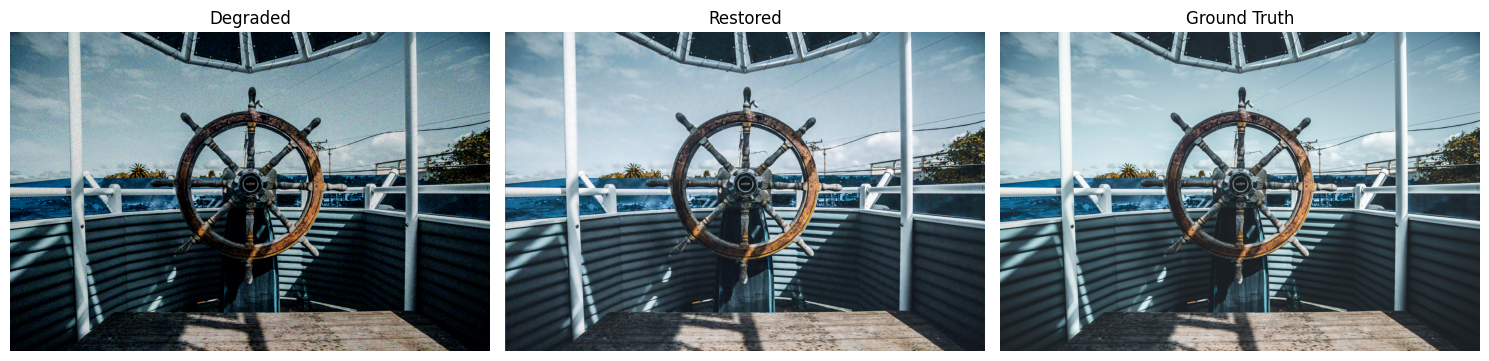

In [4]:
import matplotlib.pyplot as plt
import cv2

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(degraded_img)
axes[0].set_title("Degraded")
axes[0].axis("off")

axes[1].imshow(restored_img)
axes[1].set_title("Restored")
axes[1].axis("off")

# Load clean image for comparison
clean_bgr = cv2.imread(str(clean_path))
clean_rgb = cv2.cvtColor(clean_bgr, cv2.COLOR_BGR2RGB)

axes[2].imshow(clean_rgb)
axes[2].set_title("Ground Truth")
axes[2].axis("off")

plt.tight_layout()

# Save before showing
comparison_path = output_dir / "comparison.png"
plt.savefig(comparison_path, dpi=150, bbox_inches="tight")
print(f"\n✅ Comparison saved to {comparison_path}")

plt.show()

## 4. Evaluate on Entire Validation Set

Process all validation images and calculate metrics.

In [5]:
# Create evaluator
evaluator = ImageRestorationEvaluator(
    model=model, device=device, patch_size=256, overlap=32
)

# Evaluate dataset (use max_images for quick test)
results = evaluator.evaluate_dataset(
    degraded_dir=degraded_dir,
    clean_dir=clean_dir,
    output_dir=Path("evaluation_outputs"),  # Optional: save all restored images
    save_outputs=False,  # Set to True to save all outputs
    max_images=None,  # None for all images, or set a number for quick test
)

# Print summary
evaluator.print_summary(results)


📊 Evaluating 100 images...


Processing images:   0%|          | 0/100 [00:00<?, ?it/s]

DEBUG - sliding_window_inference input:
  image shape: torch.Size([3, 1356, 2040])
  image range: [-1.000, 1.000]
  image has NaN: False
DEBUG - First patch:
  patch range: [-1.000, 0.506]
  restored_patch range: [-0.870, 0.627]
  restored_patch has NaN: False
DEBUG - sliding_window_inference output:
  output range: [-1.197, 1.193]
  output has NaN: False
  total patches processed: 54
  weights min/max: [0.000, 1.000]
  weights has zeros: True

DEBUG - Before denorm:
  restored_tensor: [-1.197, 1.193]
  clean_tensor: [-1.000, 1.000]
DEBUG - After denorm:
  restored_denorm: [-0.099, 1.096]
  clean_denorm: [0.000, 1.000]
DEBUG - Metrics:
  PSNR: 30.707
  SSIM: 0.9116
  MAE: 0.021371
  MSE: 0.000850

DEBUG - sliding_window_inference input:
  image shape: torch.Size([3, 1356, 2040])
  image range: [-1.000, 1.000]
  image has NaN: False
DEBUG - First patch:
  patch range: [-1.000, 0.506]
  restored_patch range: [-1.044, 0.495]
  restored_patch has NaN: False
DEBUG - sliding_window_inference

## 5. Save Results

Save evaluation results to JSON for later analysis.

In [ ]:
# Save results
evaluator.save_results(results, output_dir / "evaluation_results.json")

print("\n📊 Per-image results (first 5):")
for img_metrics in results["per_image"][:5]:
    print(f"\n   {img_metrics['filename']}:")
    print(f"      PSNR: {img_metrics['psnr']:.2f} dB")
    print(f"      SSIM: {img_metrics['ssim']:.4f}")


✅ Results saved to evaluation_results.json

📊 Per-image results (first 5):

   0801.png:
      PSNR: 30.71 dB
      SSIM: 0.9116

   0802.png:
      PSNR: 29.20 dB
      SSIM: 0.7840

   0803.png:
      PSNR: 31.32 dB
      SSIM: 0.8799

   0804.png:
      PSNR: 28.55 dB
      SSIM: 0.8759

   0805.png:
      PSNR: 29.52 dB
      SSIM: 0.8266


## 6. Analyze Results

Plot distribution of metrics across the dataset.

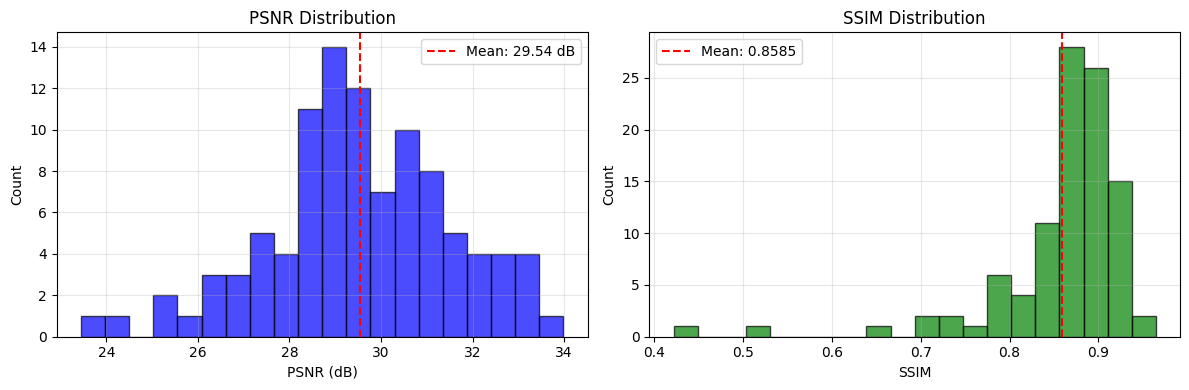


✅ Metrics distribution saved to metrics_distribution.png


In [ ]:
# Extract metrics
psnr_values = [m["psnr"] for m in results["per_image"]]
ssim_values = [m["ssim"] for m in results["per_image"]]

# Plot distributions
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].hist(psnr_values, bins=20, alpha=0.7, color="blue", edgecolor="black")
axes[0].axvline(
    results["mean"]["psnr"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['mean']['psnr']:.2f} dB",
)
axes[0].set_xlabel("PSNR (dB)")
axes[0].set_ylabel("Count")
axes[0].set_title("PSNR Distribution")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].hist(ssim_values, bins=20, alpha=0.7, color="green", edgecolor="black")
axes[1].axvline(
    results["mean"]["ssim"],
    color="red",
    linestyle="--",
    label=f"Mean: {results['mean']['ssim']:.4f}",
)
axes[1].set_xlabel("SSIM")
axes[1].set_ylabel("Count")
axes[1].set_title("SSIM Distribution")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()

# Save before showing
metrics_dist_path = output_dir / "metrics_distribution.png"
plt.savefig(metrics_dist_path, dpi=150, bbox_inches="tight")
print(f"\n✅ Metrics distribution saved to {metrics_dist_path}")

plt.show()